In [1]:
import importlib
import os
from joblib import dump, load

import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


data_path = "..\\data\\stackoverflow\\"
model_path = data_path + "models\\"

np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

# https://github.com/tensorflow/text/issues/476

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
df_lemma = pd.read_pickle(data_path + 'nltk_lemma_stop.pkl')
df_lemma_test = pd.read_pickle(data_path + 'nltk_lemma_stop_test.pkl')
df_lemma['Title'] = df_lemma['Title'].apply(lambda row: ' '.join(row))
df_lemma['Body'] = df_lemma['Body'].apply(lambda row: ' '.join(row))
df_lemma_test['Title'] = df_lemma_test['Title'].apply(lambda row: ' '.join(row))
df_lemma_test['Body'] = df_lemma_test['Body'].apply(lambda row: ' '.join(row))

In [26]:
mlb = MultiLabelBinarizer()
df_tags = pd.read_pickle(data_path + 'Top_Tags.pkl')
df_tags_test = pd.read_pickle(data_path + 'Top_Tags_test.pkl')
df_tags_full = pd.concat([df_tags,df_tags_test])
mlb.fit_transform(df_tags_full['Tags_T50'])

y_tags = mlb.transform(df_tags['Tags_T50'])
y_tags_test = mlb.transform(df_tags_test['Tags_T50'])

y_tag_python = y_tags[:,np.where(mlb.classes_=="python")]

save_mlb = False
if save_mlb:
    dump(mlb, model_path + "LSTM_model\\mlb.joblib")

# Vector Embed

In [7]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

ds_body =  tf.data.Dataset.from_tensor_slices((df_lemma['Body'][:COUNT], y_tags[:COUNT]))
ds_body_train, ds_body_valid = ds_body.take(ds_body.cardinality().numpy()*SPLIT_RATIO), ds_body.skip(ds_body.cardinality().numpy()*SPLIT_RATIO)
body_train_data = ds_body_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
body_valid_data = ds_body_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [8]:
VOCAB_SIZE = 4000
# SEQUENCE_LENGTH = 128
SEQUENCE_LENGTH = 128
# NGRAMS=(1,2)
NGRAMS=None

vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
#     input_shape=(4000,),
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH,
    ngrams=NGRAMS,)

metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4, name='patr'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# text_ds = train_data.map(lambda x, y: x)
text_ds = body_train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [15]:
# EMBEDDING_DIM = 48
EMBEDDING_DIM = 48
DROPOUT = .35
LABEL_SMOOTHING =0

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, name="embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(EMBEDDING_DIM,
            activation='relu',
                ),
    tf.keras.layers.Dropout(DROPOUT),
#     tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu', 
#                 ),
#     tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(51, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.03)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
# model.summary()

In [16]:
history = model.fit(
    body_train_data,
    epochs=10,
    validation_data=body_valid_data,
)

Epoch 1/10
2411/2411 [==============================] - 34s 14ms/step - loss: 0.1506 - patr: 0.2281 - recall: 0.1763 - auc: 0.8461 - fp: 7664.0344 - fn: 70390.3412 - tp: 11904.7790 - accuracy: 0.9728 - precision: 0.6086 - val_loss: 0.0960 - val_patr: 0.2881 - val_recall: 0.0715 - val_auc: 0.8830 - val_fp: 1333.0000 - val_fn: 26719.0000 - val_tp: 2058.0000 - val_accuracy: 0.9715 - val_precision: 0.6069
Epoch 2/10
2411/2411 [==============================] - 32s 13ms/step - loss: 0.0904 - patr: 0.3630 - recall: 0.1192 - auc: 0.8964 - fp: 3786.8437 - fn: 49513.4851 - tp: 7849.1215 - accuracy: 0.9726 - precision: 0.6528 - val_loss: 0.0727 - val_patr: 0.6352 - val_recall: 0.2320 - val_auc: 0.9424 - val_fp: 1900.0000 - val_fn: 22100.0000 - val_tp: 6677.0000 - val_accuracy: 0.9756 - val_precision: 0.7785
Epoch 3/10
2411/2411 [==============================] - 32s 13ms/step - loss: 0.0736 - patr: 0.6125 - recall: 0.2660 - auc: 0.9383 - fp: 5525.6285 - fn: 41678.4871 - tp: 15684.8213 - accuracy

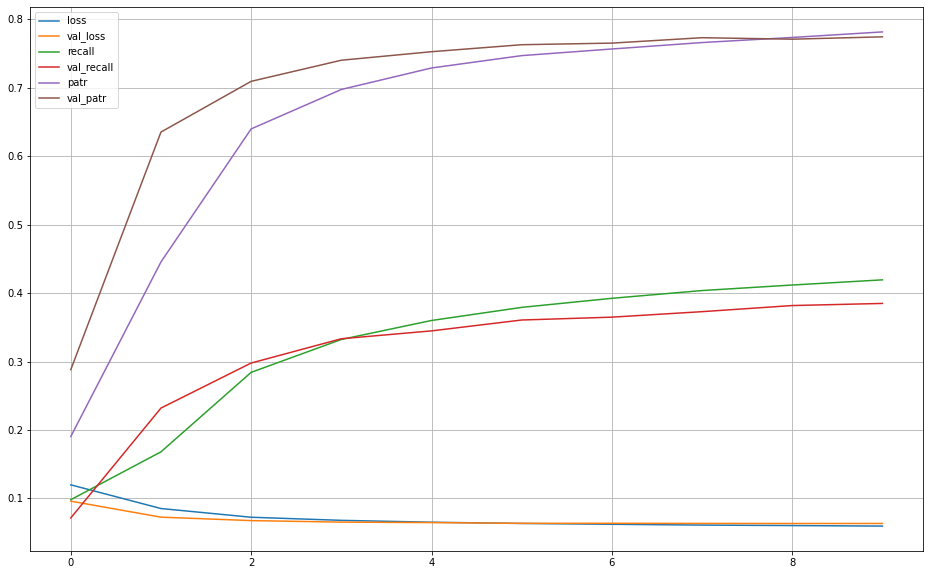

In [17]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

In [47]:
history.model

# Vector Embed Title

In [42]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

ds_title =  tf.data.Dataset.from_tensor_slices((df_lemma['Title'][:COUNT], y_tags[:COUNT]))
ds_title_train, ds_title_valid = ds_title.take(ds_title.cardinality().numpy()*SPLIT_RATIO), ds_title.skip(ds_title.cardinality().numpy()*SPLIT_RATIO)
title_train_data = ds_title_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
title_valid_data = ds_title_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [43]:
VOCAB_SIZE = 1000
# SEQUENCE_LENGTH = 128
SEQUENCE_LENGTH = 32
# NGRAMS=(1,2)
NGRAMS=None

vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
#     input_shape=(4000,),
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH,
    ngrams=NGRAMS,)

metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4, name='patr'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# text_ds = train_data.map(lambda x, y: x)
text_ds = title_train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [44]:
EMBEDDING_DIM = 32
DROPOUT = .25
LABEL_SMOOTHING =0

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, name="embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(EMBEDDING_DIM,
            activation='relu',
                ),
    tf.keras.layers.Dropout(DROPOUT),
#     tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu', 
#                 ),
#     tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(51, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.03)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
# model.summary()

In [45]:
history = model.fit(
    title_train_data,
    epochs=5,
    validation_data=title_valid_data,
)

Epoch 1/5
2411/2411 [==============================] - 34s 14ms/step - loss: 0.1217 - patr: 0.1792 - recall: 0.0804 - auc: 0.7956 - fp: 3530.6808 - fn: 50857.3843 - tp: 6505.1716 - accuracy: 0.9698 - precision: 0.4622 - val_loss: 0.0673 - val_patr: 0.7897 - val_recall: 0.3536 - val_auc: 0.9419 - val_fp: 1928.0000 - val_fn: 18601.0000 - val_tp: 10176.0000 - val_accuracy: 0.9791 - val_precision: 0.8407
Epoch 2/5
2411/2411 [==============================] - 32s 13ms/step - loss: 0.0697 - patr: 0.7532 - recall: 0.3629 - auc: 0.9358 - fp: 5377.5854 - fn: 36225.7496 - tp: 21136.9772 - accuracy: 0.9787 - precision: 0.7940 - val_loss: 0.0634 - val_patr: 0.8369 - val_recall: 0.3953 - val_auc: 0.9490 - val_fp: 2096.0000 - val_fn: 17402.0000 - val_tp: 11375.0000 - val_accuracy: 0.9802 - val_precision: 0.8444
Epoch 3/5
2411/2411 [==============================] - 32s 13ms/step - loss: 0.0663 - patr: 0.7936 - recall: 0.3899 - auc: 0.9428 - fp: 5426.5945 - fn: 34934.2641 - tp: 22428.5460 - accuracy:

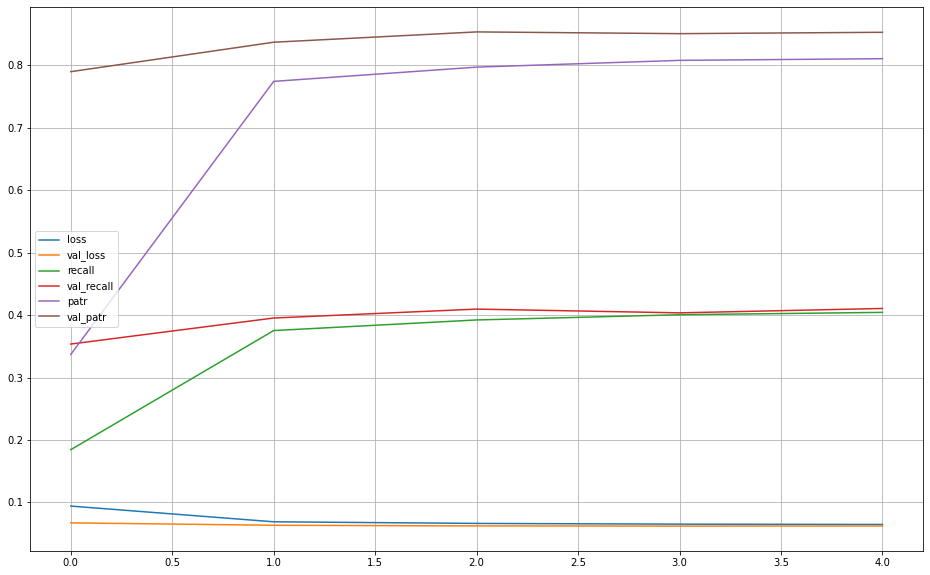

In [46]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

# Vector Embed LSTM

In [6]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 128

ds_body =  tf.data.Dataset.from_tensor_slices((df_lemma['Body'][:COUNT], y_tags[:COUNT]))
ds_body_train, ds_body_valid = ds_body.take(ds_body.cardinality().numpy()*SPLIT_RATIO), ds_body.skip(ds_body.cardinality().numpy()*SPLIT_RATIO)
body_train_data = ds_body_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
body_valid_data = ds_body_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [7]:
VOCAB_SIZE = 5000
SEQUENCE_LENGTH = 96
# NGRAMS=(1,2)

vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
#     ngrams=NGRAMS,
    output_sequence_length=SEQUENCE_LENGTH,
    )

text_ds = body_train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [8]:
# EMBEDDING_DIM = 48
EMBEDDING_DIM = 42
DROPOUT = .4
LABEL_SMOOTHING =0

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
#         mask_zero=True,
        name="embedding"),
#     tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        EMBEDDING_DIM,
#         recurrent_dropout=0.1,
    )),
    tf.keras.layers.Dense(EMBEDDING_DIM,
            activation='relu',
                ),
#     tf.keras.layers.Dropout(DROPOUT),
#     tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu', 
#                 ),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(51, activation='sigmoid'),
])

metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4, name='patr'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.02)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
# model.summary()

In [9]:
history = model.fit(
    body_train_data,
    epochs=9,
    validation_data=body_valid_data,
)

Epoch 1/9
4821/4821 [==============================] - 204s 41ms/step - loss: 0.1117 - patr: 0.1979 - recall: 0.0681 - auc: 0.8072 - fp: 3963.8179 - fn: 52149.6321 - tp: 5177.4311 - accuracy: 0.9698 - precision: 0.4478 - val_loss: 0.0721 - val_patr: 0.6391 - val_recall: 0.2738 - val_auc: 0.9404 - val_fp: 2664.0000 - val_fn: 20899.0000 - val_tp: 7878.0000 - val_accuracy: 0.9760 - val_precision: 0.7473
Epoch 2/9
 891/4821 [====>.........................] - ETA: 2:22 - loss: 0.0757 - patr: 0.5823 - recall: 0.2695 - auc: 0.9316 - fp: 1197.4310 - fn: 7653.2312 - tp: 2856.5881 - accuracy: 0.9755 - precision: 0.6988

KeyboardInterrupt: 

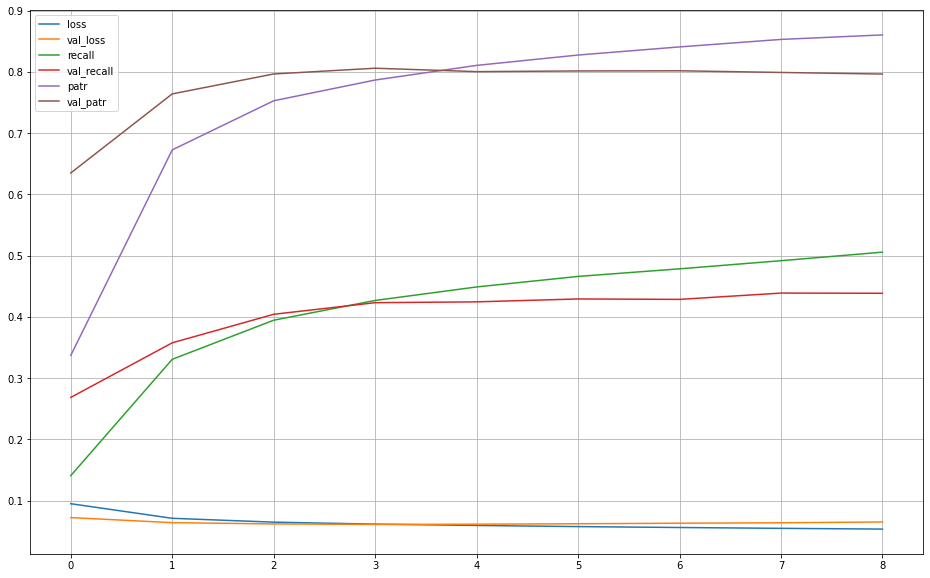

In [30]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

In [30]:
test_loss, test_acc = model.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

63/63 [==============================] - 1s 23ms/step - loss: 0.0925 - auc: 0.8844
Test Loss: 0.09254556894302368
Test Accuracy: 0.884442925453186


(0.0, 0.14245018772780896)

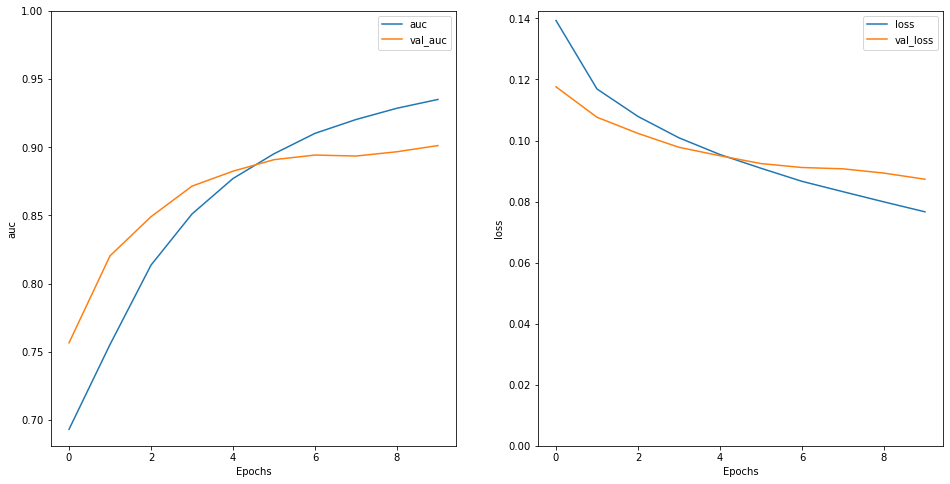

In [13]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 128

ds_title =  tf.data.Dataset.from_tensor_slices((df['Title'][:COUNT], y_tags[:COUNT]))
ds_title_train, ds_title_valid = ds_title.take(ds_title.cardinality().numpy()*SPLIT_RATIO), ds_title.skip(ds_title.cardinality().numpy()*SPLIT_RATIO)
title_train_data = ds_title_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
title_valid_data = ds_title_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
VOCAB_SIZE = 1000
SEQUENCE_LENGTH = 96
# NGRAMS=(1,2)

vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
#     ngrams=NGRAMS,
#     output_sequence_length=SEQUENCE_LENGTH,
    )

text_ds = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [ ]:
EMBEDDING_DIM = 48
DROPOUT = .4
LABEL_SMOOTHING =0

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
#         mask_zero=True,
        name="embedding"),
#     tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        EMBEDDING_DIM,
#         recurrent_dropout=0.1,
    )),
    tf.keras.layers.Dense(EMBEDDING_DIM,
            activation='relu',
                ),
#     tf.keras.layers.Dropout(DROPOUT),
#     tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu', 
#                 ),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(51, activation='sigmoid'),
])

metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4, name='patr'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.02)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
# model.summary()

In [ ]:
history = model.fit(
    train_data,
    epochs=9,
    validation_data=test_data,
)

# Vector concat

In [4]:
LABEL_SMOOTHING = 0
loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)

In [5]:
COUNT=100000
SPLIT_RATIO = .8
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 128
ds_concat =  tf.data.Dataset.from_tensor_slices(((df_lemma['Title'][:COUNT], df_lemma['Body'][:COUNT]), y_tags[:COUNT]))
ds_concat_train, ds_concat_valid = ds_concat.take(ds_concat.cardinality().numpy()*SPLIT_RATIO), ds_concat.skip(ds_concat.cardinality().numpy()*SPLIT_RATIO)
concat_train_data = ds_concat_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
concat_valid_data = ds_concat_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [6]:
metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.5, name='patr'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [7]:
TITLE_VOCAB_SIZE = 1000
TITLE_SEQUENCE_LENGTH = 32
title_vectorize_layer = TextVectorization(
    standardize = None,
    max_tokens=TITLE_VOCAB_SIZE,
    output_mode='int',
#     output_sequence_length=TITLE_SEQUENCE_LENGTH,
    name="title_vector",
    )
# title_text_ds = concat_train_data.map(lambda x, y: x)
title_vectorize_layer.adapt(df_lemma['Title'][:COUNT].values)

BODY_VOCAB_SIZE = 5000
BODY_SEQUENCE_LENGTH = 128
body_vectorize_layer = TextVectorization(
    standardize = None,
    max_tokens=BODY_VOCAB_SIZE,
    output_mode='int',
#     output_sequence_length=BODY_SEQUENCE_LENGTH,
    name="body_vector"
    )
# body_text_ds = concat_train_data.map(lambda x, y: x)
body_vectorize_layer.adapt(df_lemma['Body'][:COUNT].values)

In [8]:
TITLE_DIM = 32
LSTM_DIM = 56
BODY_EMBED_DIM = 48
CONCAT_DIM = 48

TITLE_DROPOUT = .25
LSTM_DROPOUT = .30
CONCAT_DROPOUT = .30

input_title = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="title_input")
vect_title = title_vectorize_layer(input_title)
embed_title = tf.keras.layers.Embedding(TITLE_VOCAB_SIZE, TITLE_DIM, name="title_embed")(vect_title)
pool1D_title = tf.keras.layers.GlobalAveragePooling1D(name="title_pool1")(embed_title)
dropout_title = tf.keras.layers.Dropout(TITLE_DROPOUT, name="title_dropout")(pool1D_title)
# hidden_title_2 = tf.keras.layers.Dense(DIM_TITLE, activation='relu')(dropout_title_1)
# dropout_title_2 = tf.keras.layers.Dropout(DROPOUT)(hidden_title_2)

input_body = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="body_input")
vect_body = body_vectorize_layer(input_body)
embed_body = tf.keras.layers.Embedding(
        input_dim=BODY_VOCAB_SIZE,
        output_dim=BODY_EMBED_DIM,
        name="embedding")(vect_body)
LSTM_body = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        LSTM_DIM, name='LSTM'
    ),name='BIDI_LSTM')(embed_body)
dropout_body = tf.keras.layers.Dropout(LSTM_DROPOUT, name="LSTM_dropout")(LSTM_body)

concat = tf.keras.layers.concatenate([dropout_title, dropout_body], name="concat")
hidden_concat = tf.keras.layers.Dense(CONCAT_DIM, activation='relu', name="concat_hidden")(concat)
dropout_concat = tf.keras.layers.Dropout(CONCAT_DROPOUT, name="concat_dropout")(hidden_concat)
output = tf.keras.layers.Dense(51, activation='sigmoid', name="concat_activation")(dropout_concat)
model = tf.keras.Model(inputs=[input_title, input_body], outputs=[output])

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.03)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
title_vector (TextVectorization (None, None)         0           title_input[0][0]                
__________________________________________________________________________________________________
body_vector (TextVectorization) (None, None)         0           body_input[0][0]                 
______________________________________________________________________________________________

In [9]:
# tb_callback = tf.keras.callbacks.TensorBoard(tb_logdir())
history = model.fit(
    concat_train_data,
    epochs=5,
    validation_data=concat_valid_data,
#     validation_steps=3,
#     callbacks=[tb_callback],
)

Epoch 1/5
2411/2411 [==============================] - 130s 52ms/step - loss: 0.1037 - patr: 0.2180 - recall: 0.1343 - auc: 0.8364 - fp: 4702.2699 - fn: 47375.0721 - tp: 9987.9453 - accuracy: 0.9712 - precision: 0.5661 - val_loss: 0.0591 - val_patr: 0.7240 - val_recall: 0.4045 - val_auc: 0.9617 - val_fp: 2842.0000 - val_fn: 17136.0000 - val_tp: 11641.0000 - val_accuracy: 0.9797 - val_precision: 0.8038
Epoch 2/5
2411/2411 [==============================] - 128s 53ms/step - loss: 0.0626 - patr: 0.6834 - recall: 0.4144 - auc: 0.9535 - fp: 7401.9415 - fn: 33016.7682 - tp: 24345.9407 - accuracy: 0.9793 - precision: 0.7633 - val_loss: 0.0513 - val_patr: 0.8215 - val_recall: 0.4987 - val_auc: 0.9704 - val_fp: 3051.0000 - val_fn: 14427.0000 - val_tp: 14350.0000 - val_accuracy: 0.9822 - val_precision: 0.8247
Epoch 3/5
2411/2411 [==============================] - 121s 50ms/step - loss: 0.0553 - patr: 0.7728 - recall: 0.4892 - auc: 0.9640 - fp: 7780.1604 - fn: 29099.4900 - tp: 28263.2815 - accura

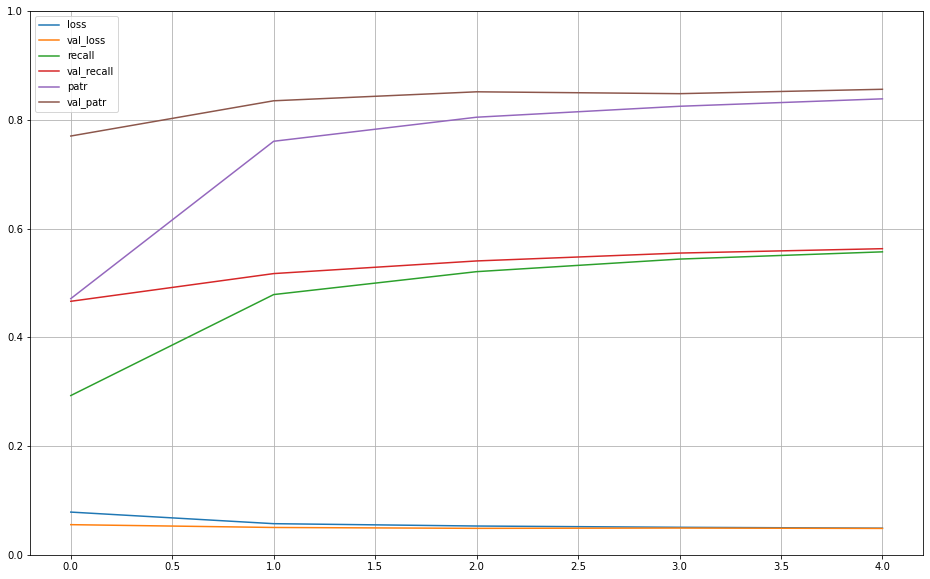

In [11]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [29]:
save=True
if save:
    model.save(model_path + "LSTM_model", overwrite=True, include_optimizer=True)
#     model.save_weights(model_path + "LSTM_weights")
else:
    saved_model = tf.keras.models.load_model(model_path + "LSTM_model")

INFO:tensorflow:Assets written to: ..\data\stackoverflow\models\LSTM_model\assets


INFO:tensorflow:Assets written to: ..\data\stackoverflow\models\LSTM_model\assets


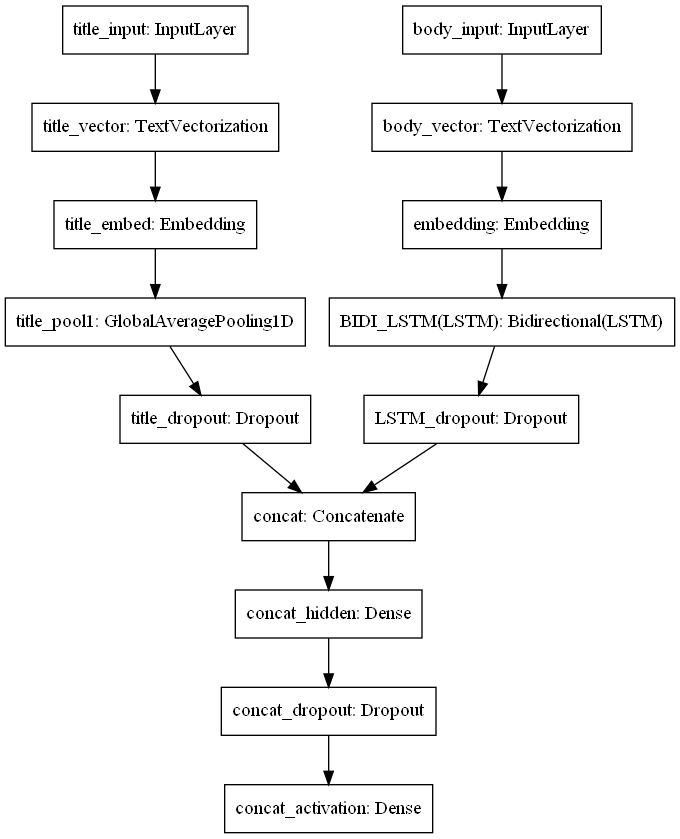

In [23]:
tf.keras.utils.plot_model(model, show_shapes=False)

In [17]:
saved_model = tf.keras.models.load_model(model_path + "LSTM_model")

In [15]:
dst = tf.data.Dataset.from_tensor_slices(["panda dataframe"])
dsb = tf.data.Dataset.from_tensor_slices(["panda"])
dspred = tf.data.Dataset.zip(((dst, dsb),)).batch(10)
res = saved_model.predict(dspred)

In [18]:
for z in np.arange(res.shape[0]):
    classes = ""
    for r in np.arange(len(mlb.classes_)):
        if res[z][r]>.05:
            classes = classes + mlb.classes_[r] + ", "
            print("r:", r , "value:", res[z][r])            
    print("classe: ", classes )

r: 10 value: 0.91260195
r: 32 value: 1.0
r: 36 value: 0.9995401
r: 37 value: 0.09092887
classe:  dataframe, pandas, python, python-3.x, 


In [10]:
mlb.inverse_transform(y_tags[8750:8760])

[('amazon-web-services', 'python'),
 ('python',),
 ('r',),
 ('pandas', 'python'),
 ('c',),
 ('amazon-web-services',),
 ('arrays', 'javascript', 'typescript'),
 ('c#',),
 ('java',),
 ('css',)]

In [23]:
dst = tf.data.Dataset.from_tensor_slices(df_lemma['Title'][2458:2459])
dsb = tf.data.Dataset.from_tensor_slices(df_lemma['Body'][2458:2459])
dspred = tf.data.Dataset.zip(((dst, dsb),)).batch(10)
print(df_lemma['Title'][2458:2459].values)
print(df_lemma['Body'][2458:2459].values)

['combine two sql query different condition']
['write query find number student gender particular class unable find write query gender write query two time gender combine union either query result query result output like preferably single query thank']


In [19]:
threshold=.2

In [27]:
res = model.predict(dspred)
for z in np.arange(res.shape[0]):
    classes = ""
    for r in np.arange(len(mlb.classes_)):
        if res[z][r]>.15:
            print("r:", r , "value:", saved_res[z][r])
            classes = classes + mlb.classes_[r] + ", "
    print("classe: ", classes )

r: 28 value: 0.306385
r: 42 value: 0.89516944
r: 43 value: 0.17051384
classe:  mysql, sql, sql-server, 


In [24]:
saved_res = saved_model.predict(dspred)
for z in np.arange(saved_res.shape[0]):
    classes = ""
    for r in np.arange(len(mlb.classes_)):
        if saved_res[z][r]>.15:
            print("r:", r , "value:", saved_res[z][r])
            classes = classes + mlb.classes_[r] + ", "
    print("classe: ", classes )

r: 28 value: 0.306385
r: 42 value: 0.89516944
r: 43 value: 0.17051384
classe:  mysql, sql, sql-server, 


In [22]:
mlb.inverse_transform(y_tags[10:20])

[('python',),
 ('other',),
 ('c++',),
 ('matplotlib', 'python'),
 ('python',),
 ('amazon-web-services',),
 ('css', 'html', 'javascript'),
 ('pandas', 'python'),
 ('javascript',),
 ('list', 'python-3.x')]

In [72]:
df_lemma['Title'][15:16].values

array(['restrict s3 sub folder level bucket policy private public'],
      dtype=object)

In [14]:
print (mlb.classes_[38])

r


In [ ]:
res = model.predict(X_test[8750:8760])
